In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

from imblearn.over_sampling import SMOTE

#1. EDA

In [4]:
# Membaca dataset
df = pd.read_csv('/content/ObesityDataSet.csv')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Age                             2097 non-null   object
 1   Gender                          2102 non-null   object
 2   Height                          2099 non-null   object
 3   Weight                          2100 non-null   object
 4   CALC                            2106 non-null   object
 5   FAVC                            2100 non-null   object
 6   FCVC                            2103 non-null   object
 7   NCP                             2099 non-null   object
 8   SCC                             2101 non-null   object
 9   SMOKE                           2106 non-null   object
 10  CH2O                            2105 non-null   object
 11  family_history_with_overweight  2098 non-null   object
 12  FAF                             2103 non-null   

In [5]:
print("Beberapa baris pertama:")
print(df.head())

Beberapa baris pertama:
  Age  Gender Height Weight        CALC FAVC FCVC NCP  SCC SMOKE CH2O  \
0  21  Female   1.62     64          no   no    2   3   no    no    2   
1  21  Female   1.52     56   Sometimes   no    3   3  yes   yes    3   
2  23    Male    1.8     77  Frequently   no    2   3   no    no    2   
3  27    Male    1.8     87  Frequently   no    3   3   no    no    2   
4  22    Male   1.78   89.8   Sometimes   no    2   1   no    no    2   

  family_history_with_overweight FAF TUE       CAEC                 MTRANS  \
0                            yes   0   1  Sometimes  Public_Transportation   
1                            yes   3   0  Sometimes  Public_Transportation   
2                            yes   2   1  Sometimes  Public_Transportation   
3                             no   2   0  Sometimes                Walking   
4                             no   0   0  Sometimes  Public_Transportation   

            NObeyesdad  
0        Normal_Weight  
1        Normal_We

In [6]:
print("\nDeskripsi Statistik:")
print(df.describe())


Deskripsi Statistik:
         Age Gender Height Weight       CALC  FAVC  FCVC   NCP   SCC SMOKE  \
count   2097   2102   2099   2100       2106  2100  2103  2099  2101  2106   
unique  1394      3   1562   1518          5     3   808   637     3     3   
top       18   Male    1.7     80  Sometimes   yes     3     3    no    no   
freq     124   1056     58     58       1386  1844   647  1183  1997  2054   

        CH2O family_history_with_overweight   FAF   TUE       CAEC  \
count   2105                           2098  2103  2102       2100   
unique  1263                              3  1186  1130          5   
top        2                            yes     0     0  Sometimes   
freq     441                           1705   404   552       1747   

                       MTRANS      NObeyesdad  
count                    2105            2111  
unique                      6               7  
top     Public_Transportation  Obesity_Type_I  
freq                     1572             35

In [7]:
#Cek missing Value
df.isnull().sum()

,0
Age,14
Gender,9
Height,12
Weight,11
CALC,5
FAVC,11
FCVC,8
NCP,12
SCC,10
SMOKE,5


In [8]:
#Cek unique values
df.nunique()

,0
Age,1394
Gender,3
Height,1562
Weight,1518
CALC,5
FAVC,3
FCVC,808
NCP,637
SCC,3
SMOKE,3


In [9]:
#Cek duplikasi
df.duplicated().sum()

np.int64(18)

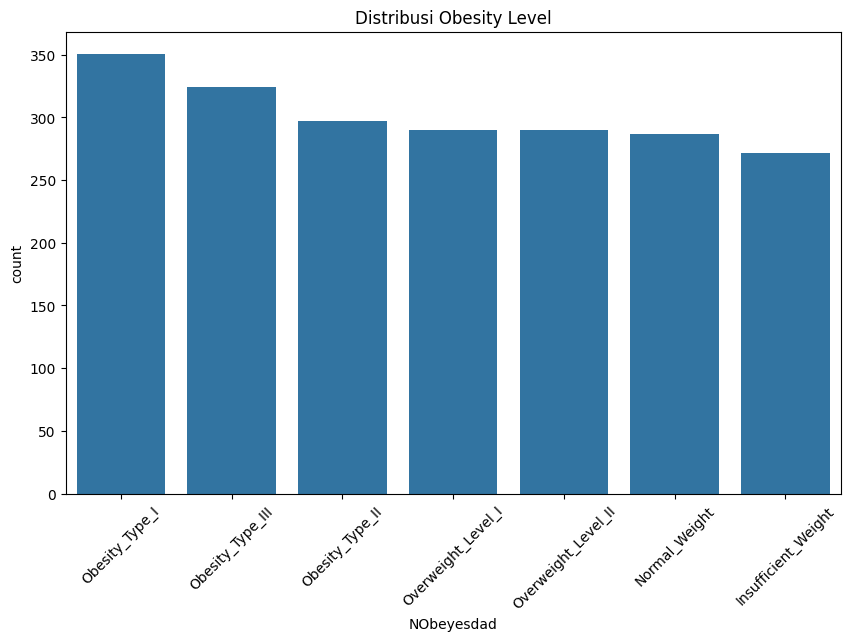

In [10]:
# Distribusi target dan visualisasi
plt.figure(figsize=(10,6))
sns.countplot(data=df, x="NObeyesdad", order=df["NObeyesdad"].value_counts().index)
plt.xticks(rotation=45)
plt.title("Distribusi Obesity Level")
plt.show()

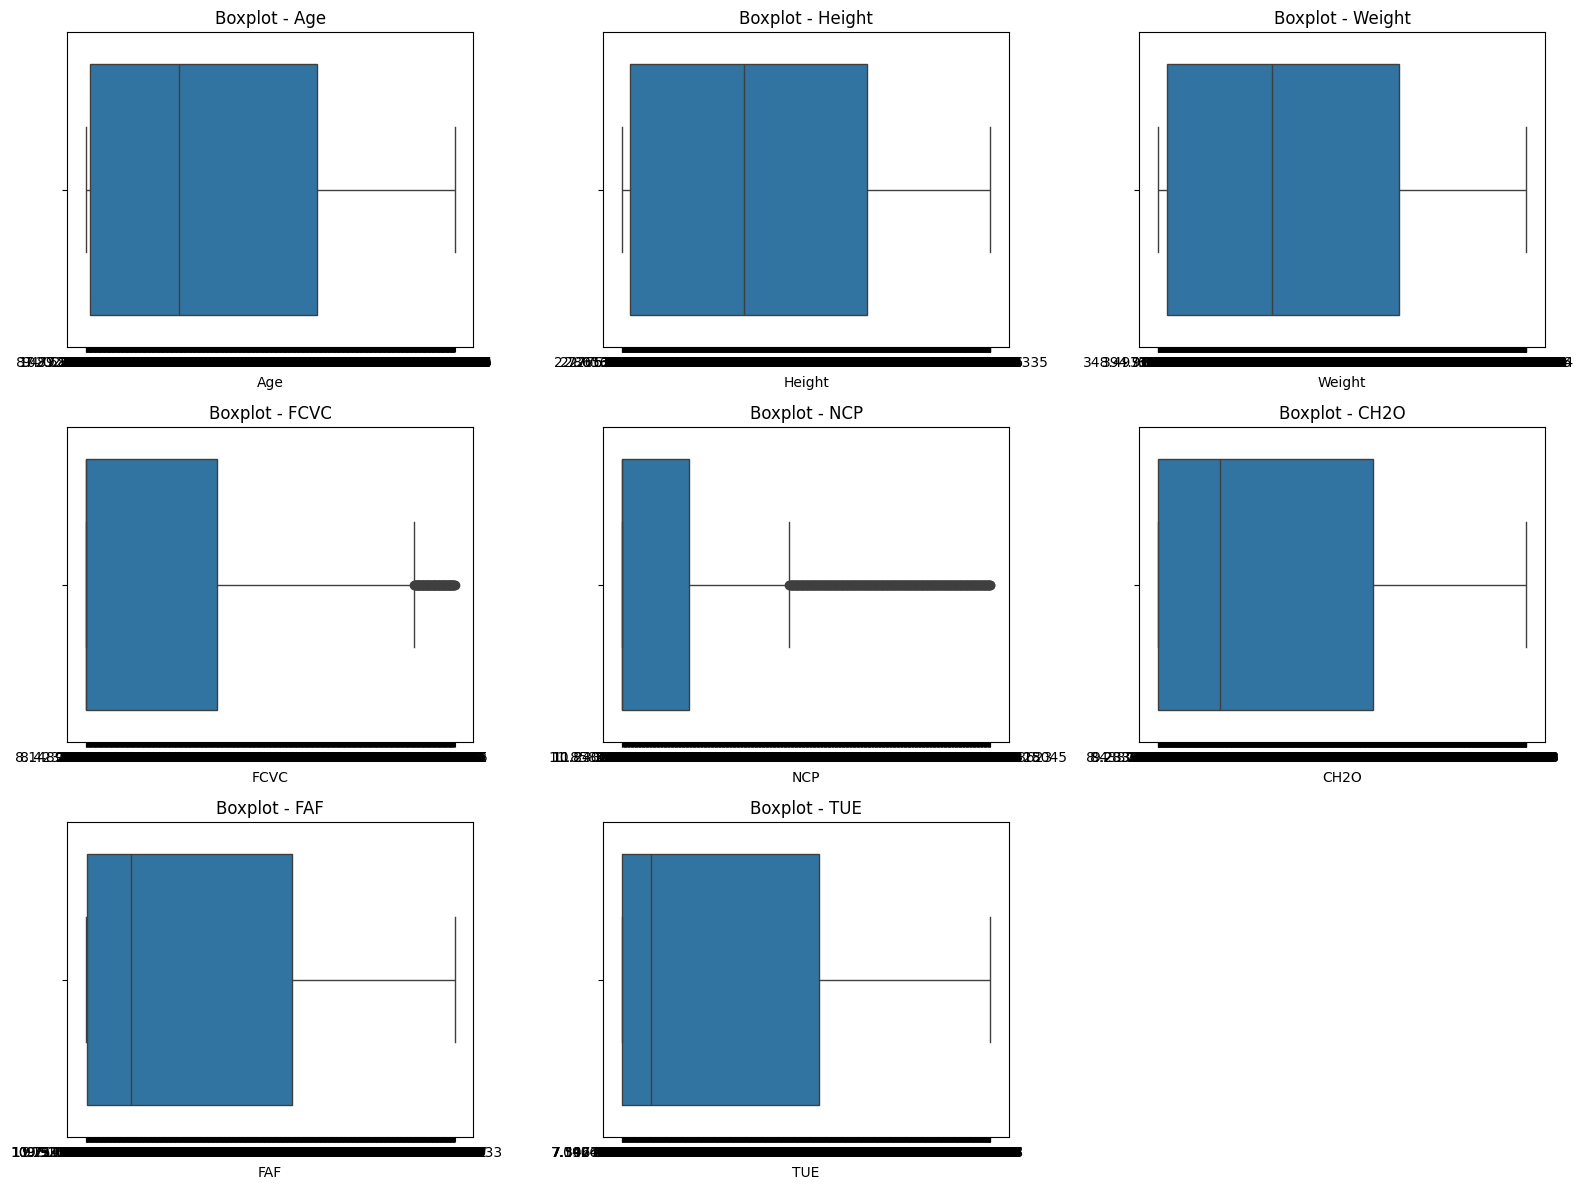

In [11]:
# Boxplot untuk deteksi outlier numerik
numerical_features = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
plt.figure(figsize=(16, 12))
for i, col in enumerate(numerical_features):
    plt.subplot(3, 3, i+1)
    sns.boxplot(data=df, x=col)
    plt.title(f'Boxplot - {col}')
plt.tight_layout()
plt.show()


#2. Preprocessing Data

In [12]:
# Menangani duplikat
print("Jumlah baris sebelum menghapus duplikat:", df.shape[0])
df = df.drop_duplicates()
print("Jumlah baris setelah menghapus duplikat:", df.shape[0])

Jumlah baris sebelum menghapus duplikat: 2111
Jumlah baris setelah menghapus duplikat: 2093


In [13]:
# Sebelum hapus outlier Weight:
print("Jumlah baris sebelum menghapus outlier Weight:", df.shape[0])

# Periksa nilai non-numerik di kolom 'Weight' dan konversi ke numerik
# Parameter 'errors='coerce'' akan mengubah nilai non-numerik menjadi NaN
df['Weight'] = pd.to_numeric(df['Weight'], errors='coerce')

# Hapus baris dengan nilai NaN di kolom 'Weight' yang mungkin muncul setelah konversi
df.dropna(subset=['Weight'], inplace=True)

# Hitung Q1 dan Q3 setelah memastikan kolom 'Weight' hanya berisi angka
Q1 = df['Weight'].quantile(0.25)
Q3 = df['Weight'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['Weight'] >= Q1 - 1.5 * IQR) & (df['Weight'] <= Q3 + 1.5 * IQR)]
print("Jumlah baris setelah menghapus outlier Weight:", df.shape[0])

Jumlah baris sebelum menghapus outlier Weight: 2093
Jumlah baris setelah menghapus outlier Weight: 2059


<ipython-input-13-f89c201e912a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Weight'] = pd.to_numeric(df['Weight'], errors='coerce')
<ipython-input-13-f89c201e912a>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=['Weight'], inplace=True)


In [14]:
le = LabelEncoder()
df['NObeyesdad'] = le.fit_transform(df['NObeyesdad'])
print("Label target setelah encoding:", df['NObeyesdad'].unique())

Label target setelah encoding: [1 5 6 2 0 3 4]


In [24]:
# Definisikan fitur numerik dan kategorikal
numerical_features = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
categorical_features = ['Gender', 'Age', 'Height', 'Weight', 'CALC', 'FAVC', 'SCC', 'MTRANS'] # Sesuaikan dengan kolom kategorikal di dataset Anda

numerical = numerical_features
categorical = categorical_features

print("Fitur numerik:", numerical)
print("Fitur kategorikal:", categorical)

Fitur numerik: ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
Fitur kategorikal: ['Gender', 'Age', 'Height', 'Weight', 'CALC', 'FAVC', 'SCC', 'MTRANS']


In [28]:
X = df.drop('NObeyesdad', axis=1)
y = df['NObeyesdad']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


numerical_features = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
categorical_features = ['Gender', 'CALC', 'FAVC', 'SCC', 'MTRANS']

print("Checking numerical features for non-numeric values and handling them...")
for col in numerical_features:
    if col in X_train.columns:


        X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
        X_test[col] = pd.to_numeric(X_test[col], errors='coerce')

        initial_rows_train = X_train.shape[0]
        initial_rows_test = X_test.shape[0]
        X_train.dropna(subset=[col], inplace=True)
        X_test.dropna(subset=[col], inplace=True)

        y_train = y_train.loc[X_train.index]
        y_test = y_test.loc[X_test.index]
        if X_train.shape[0] < initial_rows_train:
            print(f"Dropped {initial_rows_train - X_train.shape[0]} rows with non-numeric or missing values in '{col}' from training data.")
        if X_test.shape[0] < initial_rows_test:
             print(f"Dropped {initial_rows_test - X_test.shape[0]} rows with non-numeric or missing values in '{col}' from testing data.")
    else:
        print(f"Warning: Numerical feature '{col}' not found in the dataframe columns.")
print("Cleaning of numerical features complete.")



numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)


X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)


print("Shape data train setelah scaling:", X_train_scaled.shape)
print("Shape data test setelah scaling:", X_test_scaled.shape)


Checking numerical features for non-numeric values and handling them...
Dropped 17 rows with non-numeric or missing values in 'Age' from training data.
Dropped 5 rows with non-numeric or missing values in 'Age' from testing data.
Dropped 19 rows with non-numeric or missing values in 'Height' from training data.
Dropped 3 rows with non-numeric or missing values in 'Height' from testing data.
Dropped 14 rows with non-numeric or missing values in 'FCVC' from training data.
Dropped 4 rows with non-numeric or missing values in 'FCVC' from testing data.
Dropped 15 rows with non-numeric or missing values in 'NCP' from training data.
Dropped 7 rows with non-numeric or missing values in 'NCP' from testing data.
Dropped 12 rows with non-numeric or missing values in 'CH2O' from training data.
Dropped 3 rows with non-numeric or missing values in 'CH2O' from testing data.
Dropped 15 rows with non-numeric or missing values in 'FAF' from training data.
Dropped 4 rows with non-numeric or missing value

In [30]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

print("Sebelum SMOTE:", np.bincount(y_train))
print("Setelah SMOTE:", np.bincount(y_train_res))

Sebelum SMOTE: [198 209 263 224 234 206 208]
Setelah SMOTE: [263 263 263 263 263 263 263]
